# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

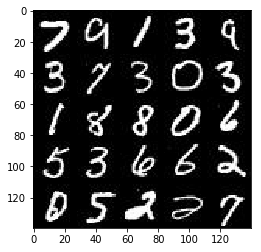

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

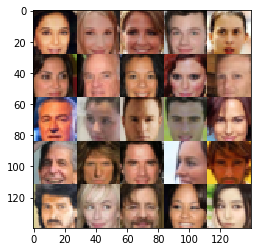

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1;
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        dropout1 = tf.nn.dropout(relu1, .8)
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, .8)
        
        x3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropout3 = tf.nn.dropout(relu3, .8)
        
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        dropout1 = tf.nn.dropout(relu1, .8)
#         7x7x512
        x2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, .8)
#         14x14x256
        x3 = tf.layers.conv2d_transpose(dropout2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropout3 = tf.nn.dropout(relu3, .8)
        
        
        logits = tf.layers.conv2d_transpose(dropout3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # 28 x 28 x out_channel_dim images.
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*.9)
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, num_channels = data_shape
    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, num_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, num_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
#     lossess = []
    steps = 0
    show_every = 100
    print_every = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                 需要将real images 进行标准化
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_input: learning_rate})
                
                if steps % show_every == 0:
                    show_generator_output(sess, 64, input_z, num_channels, data_image_mode)
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Step: {}'.format(steps),
                         'Epoch {}/{}...'.format(epoch_i, epochs),
                         'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                         'Generator Loss: {:.4f}...'.format(train_loss_g))
                    
#                     losses.append((train_loss_d, train_loss_g))
                

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 20 Epoch 0/2... Discriminator Loss: 1.3961... Generator Loss: 1.2630...
Step: 40 Epoch 0/2... Discriminator Loss: 1.6071... Generator Loss: 2.9468...
Step: 60 Epoch 0/2... Discriminator Loss: 1.2350... Generator Loss: 0.9164...
Step: 80 Epoch 0/2... Discriminator Loss: 1.5714... Generator Loss: 0.7631...


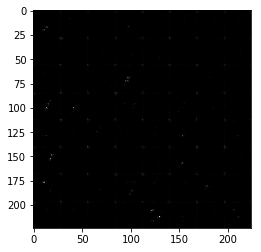

Step: 100 Epoch 0/2... Discriminator Loss: 1.4976... Generator Loss: 0.8691...
Step: 120 Epoch 0/2... Discriminator Loss: 1.6629... Generator Loss: 0.3846...
Step: 140 Epoch 0/2... Discriminator Loss: 1.4863... Generator Loss: 0.6769...
Step: 160 Epoch 0/2... Discriminator Loss: 1.4968... Generator Loss: 0.5207...
Step: 180 Epoch 0/2... Discriminator Loss: 1.3603... Generator Loss: 0.7660...


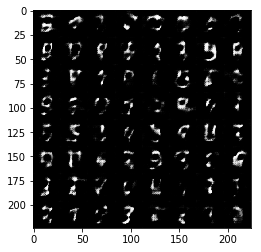

Step: 200 Epoch 0/2... Discriminator Loss: 1.2305... Generator Loss: 0.9464...
Step: 220 Epoch 0/2... Discriminator Loss: 1.2110... Generator Loss: 1.2924...
Step: 240 Epoch 0/2... Discriminator Loss: 1.5203... Generator Loss: 0.6585...
Step: 260 Epoch 0/2... Discriminator Loss: 1.2834... Generator Loss: 1.2959...
Step: 280 Epoch 0/2... Discriminator Loss: 1.2424... Generator Loss: 0.9726...


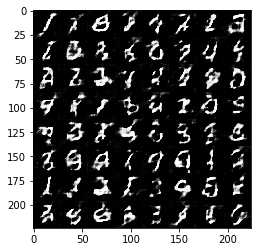

Step: 300 Epoch 0/2... Discriminator Loss: 1.1858... Generator Loss: 0.9200...
Step: 320 Epoch 0/2... Discriminator Loss: 1.3688... Generator Loss: 0.8412...
Step: 340 Epoch 0/2... Discriminator Loss: 1.2900... Generator Loss: 0.9773...
Step: 360 Epoch 0/2... Discriminator Loss: 1.7335... Generator Loss: 0.4153...
Step: 380 Epoch 0/2... Discriminator Loss: 1.2353... Generator Loss: 1.0603...


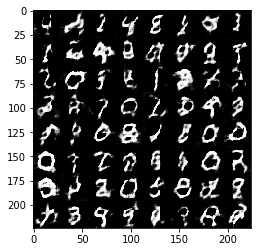

Step: 400 Epoch 0/2... Discriminator Loss: 1.3879... Generator Loss: 0.5938...
Step: 420 Epoch 0/2... Discriminator Loss: 1.1686... Generator Loss: 0.8305...
Step: 440 Epoch 0/2... Discriminator Loss: 1.2417... Generator Loss: 1.1306...
Step: 460 Epoch 0/2... Discriminator Loss: 1.1923... Generator Loss: 0.8370...
Step: 480 Epoch 0/2... Discriminator Loss: 1.1708... Generator Loss: 1.5710...


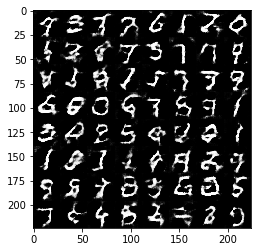

Step: 500 Epoch 0/2... Discriminator Loss: 1.3168... Generator Loss: 1.1854...
Step: 520 Epoch 0/2... Discriminator Loss: 1.1417... Generator Loss: 1.0480...
Step: 540 Epoch 0/2... Discriminator Loss: 1.2302... Generator Loss: 1.0565...
Step: 560 Epoch 0/2... Discriminator Loss: 1.0171... Generator Loss: 1.2959...
Step: 580 Epoch 0/2... Discriminator Loss: 1.1985... Generator Loss: 1.3582...


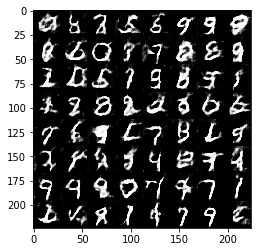

Step: 600 Epoch 0/2... Discriminator Loss: 1.1026... Generator Loss: 1.0913...
Step: 620 Epoch 0/2... Discriminator Loss: 1.1819... Generator Loss: 0.9747...
Step: 640 Epoch 0/2... Discriminator Loss: 1.3179... Generator Loss: 1.5163...
Step: 660 Epoch 0/2... Discriminator Loss: 1.1458... Generator Loss: 0.8175...
Step: 680 Epoch 0/2... Discriminator Loss: 1.1574... Generator Loss: 1.4038...


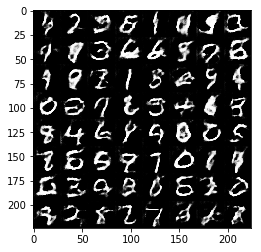

Step: 700 Epoch 0/2... Discriminator Loss: 1.3838... Generator Loss: 0.6433...
Step: 720 Epoch 0/2... Discriminator Loss: 1.3656... Generator Loss: 0.7264...
Step: 740 Epoch 0/2... Discriminator Loss: 1.1891... Generator Loss: 1.1656...
Step: 760 Epoch 0/2... Discriminator Loss: 1.2253... Generator Loss: 1.1069...
Step: 780 Epoch 0/2... Discriminator Loss: 1.1545... Generator Loss: 0.8558...


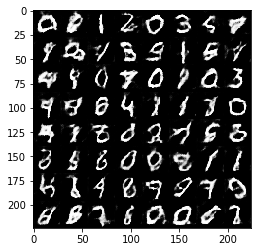

Step: 800 Epoch 0/2... Discriminator Loss: 1.1966... Generator Loss: 0.9303...
Step: 820 Epoch 0/2... Discriminator Loss: 1.2671... Generator Loss: 0.9211...
Step: 840 Epoch 0/2... Discriminator Loss: 1.1937... Generator Loss: 1.7317...
Step: 860 Epoch 0/2... Discriminator Loss: 1.0992... Generator Loss: 0.9008...
Step: 880 Epoch 0/2... Discriminator Loss: 1.1591... Generator Loss: 0.7874...


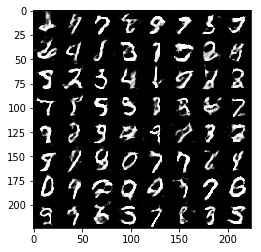

Step: 900 Epoch 0/2... Discriminator Loss: 1.1240... Generator Loss: 0.8686...
Step: 920 Epoch 0/2... Discriminator Loss: 1.4482... Generator Loss: 1.5826...
Step: 940 Epoch 0/2... Discriminator Loss: 1.2706... Generator Loss: 0.8751...
Step: 960 Epoch 0/2... Discriminator Loss: 1.1240... Generator Loss: 1.7479...
Step: 980 Epoch 0/2... Discriminator Loss: 1.1769... Generator Loss: 0.8996...


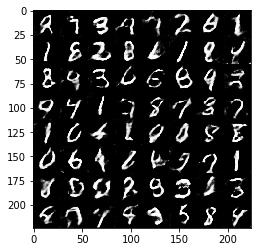

Step: 1000 Epoch 0/2... Discriminator Loss: 1.5683... Generator Loss: 0.4296...
Step: 1020 Epoch 0/2... Discriminator Loss: 0.9493... Generator Loss: 1.3682...
Step: 1040 Epoch 0/2... Discriminator Loss: 1.1085... Generator Loss: 1.3100...
Step: 1060 Epoch 0/2... Discriminator Loss: 1.1831... Generator Loss: 0.8750...
Step: 1080 Epoch 0/2... Discriminator Loss: 1.2822... Generator Loss: 2.1685...


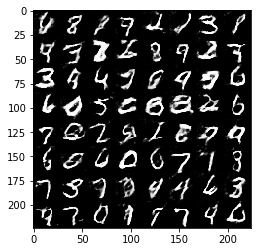

Step: 1100 Epoch 0/2... Discriminator Loss: 1.2416... Generator Loss: 0.9515...
Step: 1120 Epoch 0/2... Discriminator Loss: 1.3093... Generator Loss: 0.5825...
Step: 1140 Epoch 0/2... Discriminator Loss: 1.0163... Generator Loss: 0.8318...
Step: 1160 Epoch 0/2... Discriminator Loss: 1.1961... Generator Loss: 1.1003...
Step: 1180 Epoch 0/2... Discriminator Loss: 1.2018... Generator Loss: 0.7660...


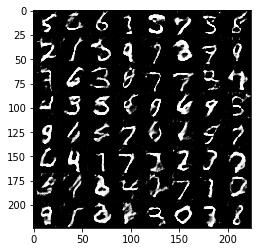

Step: 1200 Epoch 0/2... Discriminator Loss: 1.0653... Generator Loss: 0.8433...
Step: 1220 Epoch 0/2... Discriminator Loss: 1.5561... Generator Loss: 0.3604...
Step: 1240 Epoch 0/2... Discriminator Loss: 1.0761... Generator Loss: 1.0497...
Step: 1260 Epoch 0/2... Discriminator Loss: 1.1000... Generator Loss: 0.7986...
Step: 1280 Epoch 0/2... Discriminator Loss: 1.1037... Generator Loss: 1.1573...


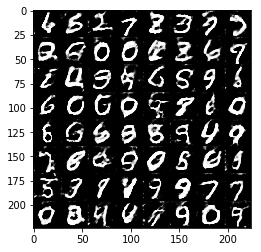

Step: 1300 Epoch 0/2... Discriminator Loss: 0.9863... Generator Loss: 1.4253...
Step: 1320 Epoch 0/2... Discriminator Loss: 0.9387... Generator Loss: 0.9663...
Step: 1340 Epoch 0/2... Discriminator Loss: 1.2746... Generator Loss: 0.6940...
Step: 1360 Epoch 0/2... Discriminator Loss: 0.9616... Generator Loss: 1.2691...
Step: 1380 Epoch 0/2... Discriminator Loss: 1.0145... Generator Loss: 1.2176...


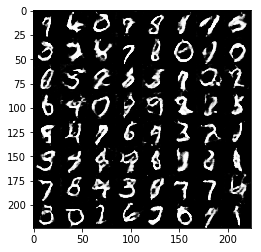

Step: 1400 Epoch 0/2... Discriminator Loss: 1.1204... Generator Loss: 1.7027...
Step: 1420 Epoch 0/2... Discriminator Loss: 1.1286... Generator Loss: 1.3344...
Step: 1440 Epoch 0/2... Discriminator Loss: 1.3597... Generator Loss: 0.7573...
Step: 1460 Epoch 0/2... Discriminator Loss: 0.8697... Generator Loss: 1.3290...
Step: 1480 Epoch 0/2... Discriminator Loss: 1.6922... Generator Loss: 0.7260...


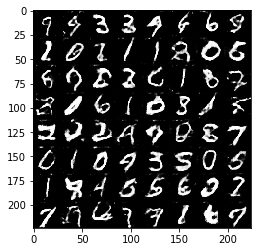

Step: 1500 Epoch 0/2... Discriminator Loss: 1.0026... Generator Loss: 1.5042...
Step: 1520 Epoch 0/2... Discriminator Loss: 1.0910... Generator Loss: 1.0007...
Step: 1540 Epoch 0/2... Discriminator Loss: 0.8759... Generator Loss: 1.5051...
Step: 1560 Epoch 0/2... Discriminator Loss: 0.9732... Generator Loss: 1.9668...
Step: 1580 Epoch 0/2... Discriminator Loss: 1.2906... Generator Loss: 0.5946...


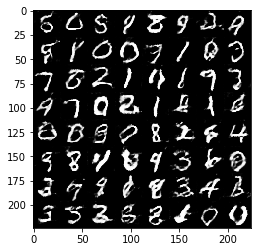

Step: 1600 Epoch 0/2... Discriminator Loss: 1.1992... Generator Loss: 0.9878...
Step: 1620 Epoch 0/2... Discriminator Loss: 1.0354... Generator Loss: 1.0126...
Step: 1640 Epoch 0/2... Discriminator Loss: 1.1876... Generator Loss: 0.7107...
Step: 1660 Epoch 0/2... Discriminator Loss: 1.0860... Generator Loss: 1.3837...
Step: 1680 Epoch 0/2... Discriminator Loss: 1.4068... Generator Loss: 0.5922...


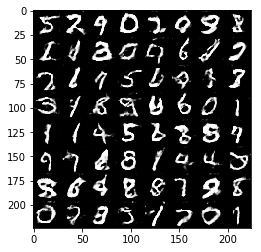

Step: 1700 Epoch 0/2... Discriminator Loss: 1.1147... Generator Loss: 0.7841...
Step: 1720 Epoch 0/2... Discriminator Loss: 0.9194... Generator Loss: 1.4015...
Step: 1740 Epoch 0/2... Discriminator Loss: 0.8761... Generator Loss: 1.1243...
Step: 1760 Epoch 0/2... Discriminator Loss: 1.0988... Generator Loss: 1.0001...
Step: 1780 Epoch 0/2... Discriminator Loss: 0.7566... Generator Loss: 1.7547...


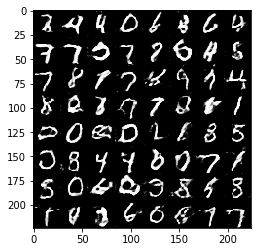

Step: 1800 Epoch 0/2... Discriminator Loss: 1.1175... Generator Loss: 1.7612...
Step: 1820 Epoch 0/2... Discriminator Loss: 0.8056... Generator Loss: 1.0144...
Step: 1840 Epoch 0/2... Discriminator Loss: 0.9519... Generator Loss: 1.4827...
Step: 1860 Epoch 0/2... Discriminator Loss: 1.0235... Generator Loss: 0.9286...
Step: 1880 Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.7461...


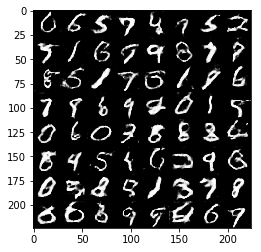

Step: 1900 Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.3191...
Step: 1920 Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 2.1269...
Step: 1940 Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.1723...
Step: 1960 Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.7991...
Step: 1980 Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.5257...


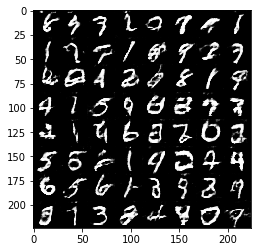

Step: 2000 Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 2.1788...
Step: 2020 Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.7039...
Step: 2040 Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 2.1368...
Step: 2060 Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.9588...
Step: 2080 Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.9887...


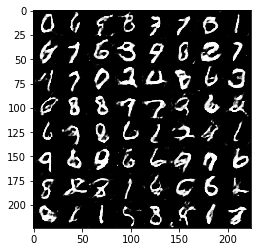

Step: 2100 Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.7441...
Step: 2120 Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 0.8567...
Step: 2140 Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.1649...
Step: 2160 Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.9815...
Step: 2180 Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.5480...


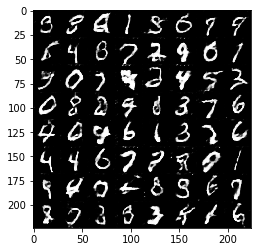

Step: 2200 Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 2.1718...
Step: 2220 Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 0.9449...
Step: 2240 Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 2.6106...
Step: 2260 Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 0.9717...
Step: 2280 Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 1.8478...


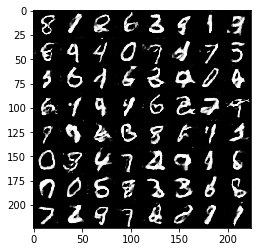

Step: 2300 Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.1679...
Step: 2320 Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 1.0778...
Step: 2340 Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 1.2883...
Step: 2360 Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 0.8579...
Step: 2380 Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 1.4050...


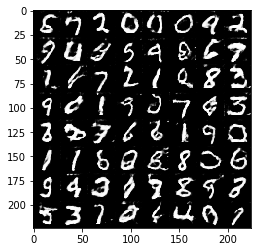

Step: 2400 Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.1201...
Step: 2420 Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 2.4333...
Step: 2440 Epoch 1/2... Discriminator Loss: 0.6434... Generator Loss: 1.8025...
Step: 2460 Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.5850...
Step: 2480 Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.7698...


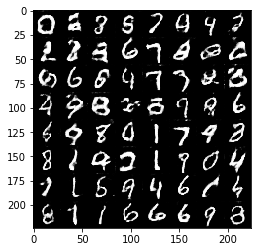

Step: 2500 Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.2353...
Step: 2520 Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.3792...
Step: 2540 Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.6351...
Step: 2560 Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.9999...
Step: 2580 Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.7142...


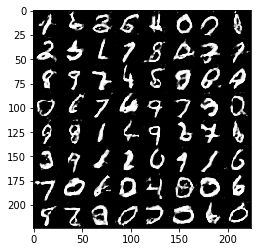

Step: 2600 Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 2.2108...
Step: 2620 Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 1.4007...
Step: 2640 Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.8292...
Step: 2660 Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 2.1557...
Step: 2680 Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 2.6906...


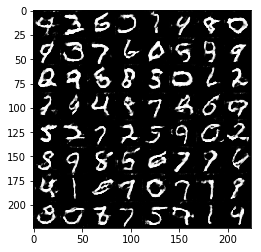

Step: 2700 Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 2.0899...
Step: 2720 Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.4407...
Step: 2740 Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.7060...
Step: 2760 Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 2.3341...
Step: 2780 Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 2.7976...


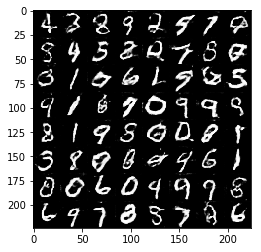

Step: 2800 Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 2.0168...
Step: 2820 Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 2.4400...
Step: 2840 Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.2289...
Step: 2860 Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.2710...
Step: 2880 Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 0.6946...


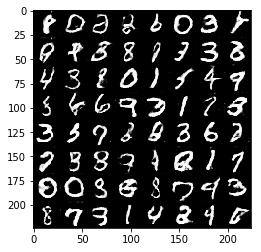

Step: 2900 Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.6008...
Step: 2920 Epoch 1/2... Discriminator Loss: 0.6208... Generator Loss: 2.0321...
Step: 2940 Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 1.2905...
Step: 2960 Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 2.0808...
Step: 2980 Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.2956...


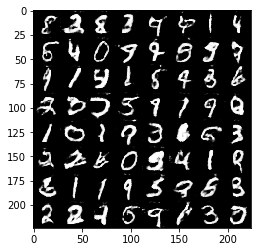

Step: 3000 Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 2.7354...
Step: 3020 Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.9798...
Step: 3040 Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.6289...
Step: 3060 Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 0.9309...
Step: 3080 Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.9523...


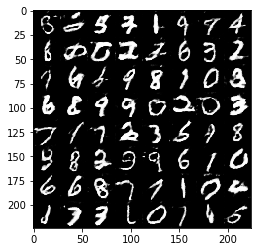

Step: 3100 Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 2.8555...
Step: 3120 Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.7255...
Step: 3140 Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 3.7662...
Step: 3160 Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 2.1533...
Step: 3180 Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 2.6505...


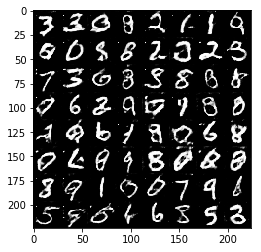

Step: 3200 Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 2.1308...
Step: 3220 Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 2.6693...
Step: 3240 Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.9142...
Step: 3260 Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 1.2900...
Step: 3280 Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 2.2753...


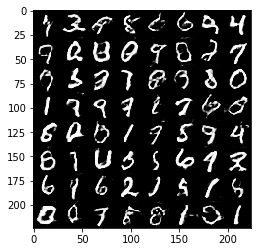

Step: 3300 Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 2.0387...
Step: 3320 Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 2.5533...
Step: 3340 Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 2.7613...
Step: 3360 Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 2.4877...
Step: 3380 Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.2623...


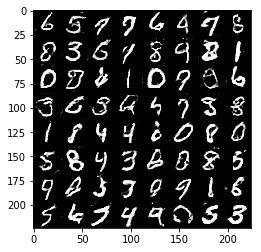

Step: 3400 Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 1.0738...
Step: 3420 Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 1.6618...
Step: 3440 Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.5518...
Step: 3460 Epoch 1/2... Discriminator Loss: 0.5814... Generator Loss: 2.7295...
Step: 3480 Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.9743...


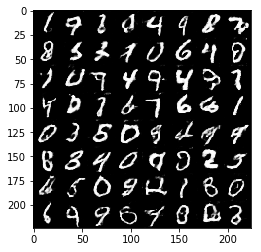

Step: 3500 Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 2.5553...
Step: 3520 Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 2.8384...
Step: 3540 Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 1.9400...
Step: 3560 Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 2.3829...
Step: 3580 Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 2.5717...


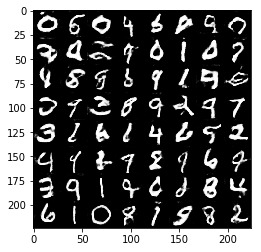

Step: 3600 Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.9549...
Step: 3620 Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.2331...
Step: 3640 Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.2099...
Step: 3660 Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 1.9834...
Step: 3680 Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.2141...


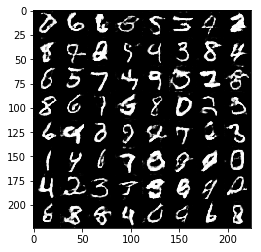

Step: 3700 Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 1.9978...
Step: 3720 Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.0032...
Step: 3740 Epoch 1/2... Discriminator Loss: 0.6929... Generator Loss: 1.9191...


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 20 Epoch 0/1... Discriminator Loss: 1.9006... Generator Loss: 9.2219...
Step: 40 Epoch 0/1... Discriminator Loss: 0.9840... Generator Loss: 1.5688...
Step: 60 Epoch 0/1... Discriminator Loss: 1.4157... Generator Loss: 0.6755...
Step: 80 Epoch 0/1... Discriminator Loss: 0.9516... Generator Loss: 0.9363...


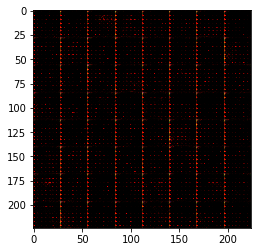

Step: 100 Epoch 0/1... Discriminator Loss: 1.1319... Generator Loss: 1.2055...
Step: 120 Epoch 0/1... Discriminator Loss: 1.2268... Generator Loss: 2.7081...
Step: 140 Epoch 0/1... Discriminator Loss: 1.1512... Generator Loss: 0.7970...
Step: 160 Epoch 0/1... Discriminator Loss: 1.3218... Generator Loss: 2.1784...
Step: 180 Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 1.5438...


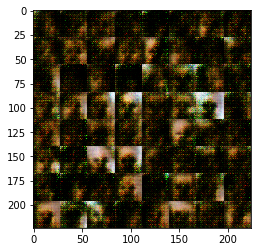

Step: 200 Epoch 0/1... Discriminator Loss: 1.0032... Generator Loss: 1.0657...
Step: 220 Epoch 0/1... Discriminator Loss: 1.2861... Generator Loss: 0.6166...
Step: 240 Epoch 0/1... Discriminator Loss: 1.1544... Generator Loss: 1.2112...
Step: 260 Epoch 0/1... Discriminator Loss: 1.2956... Generator Loss: 0.8040...
Step: 280 Epoch 0/1... Discriminator Loss: 1.1357... Generator Loss: 1.0066...


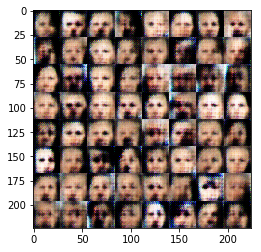

Step: 300 Epoch 0/1... Discriminator Loss: 1.2277... Generator Loss: 1.0973...
Step: 320 Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.9005...
Step: 340 Epoch 0/1... Discriminator Loss: 1.8542... Generator Loss: 2.3401...
Step: 360 Epoch 0/1... Discriminator Loss: 0.8415... Generator Loss: 1.6609...
Step: 380 Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 1.2200...


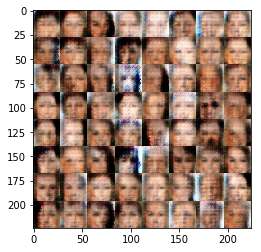

Step: 400 Epoch 0/1... Discriminator Loss: 1.2939... Generator Loss: 1.1391...
Step: 420 Epoch 0/1... Discriminator Loss: 1.7214... Generator Loss: 2.1785...
Step: 440 Epoch 0/1... Discriminator Loss: 1.8779... Generator Loss: 0.3749...
Step: 460 Epoch 0/1... Discriminator Loss: 1.5570... Generator Loss: 2.2250...
Step: 480 Epoch 0/1... Discriminator Loss: 1.1568... Generator Loss: 2.0252...


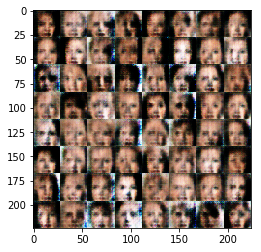

Step: 500 Epoch 0/1... Discriminator Loss: 1.0074... Generator Loss: 1.1360...
Step: 520 Epoch 0/1... Discriminator Loss: 0.8167... Generator Loss: 1.5104...
Step: 540 Epoch 0/1... Discriminator Loss: 0.8891... Generator Loss: 1.5075...
Step: 560 Epoch 0/1... Discriminator Loss: 0.8182... Generator Loss: 1.1633...
Step: 580 Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 0.7136...


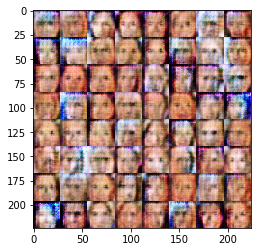

Step: 600 Epoch 0/1... Discriminator Loss: 1.6094... Generator Loss: 0.7976...
Step: 620 Epoch 0/1... Discriminator Loss: 1.3653... Generator Loss: 1.8600...
Step: 640 Epoch 0/1... Discriminator Loss: 1.0113... Generator Loss: 1.0935...
Step: 660 Epoch 0/1... Discriminator Loss: 1.5959... Generator Loss: 0.5103...
Step: 680 Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 1.0309...


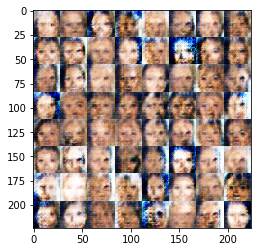

Step: 700 Epoch 0/1... Discriminator Loss: 1.3759... Generator Loss: 0.7907...
Step: 720 Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 1.5538...
Step: 740 Epoch 0/1... Discriminator Loss: 1.6016... Generator Loss: 1.7726...
Step: 760 Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 0.9464...
Step: 780 Epoch 0/1... Discriminator Loss: 1.7029... Generator Loss: 0.4150...


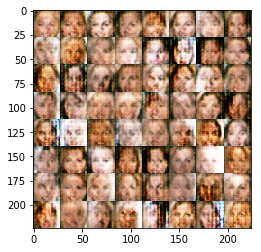

Step: 800 Epoch 0/1... Discriminator Loss: 1.2728... Generator Loss: 0.8726...
Step: 820 Epoch 0/1... Discriminator Loss: 1.3889... Generator Loss: 0.6967...
Step: 840 Epoch 0/1... Discriminator Loss: 1.2763... Generator Loss: 0.6374...
Step: 860 Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 1.1212...
Step: 880 Epoch 0/1... Discriminator Loss: 1.1073... Generator Loss: 0.9289...


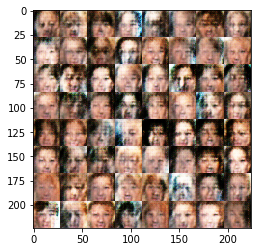

Step: 900 Epoch 0/1... Discriminator Loss: 1.3057... Generator Loss: 0.8593...
Step: 920 Epoch 0/1... Discriminator Loss: 1.4218... Generator Loss: 0.8656...
Step: 940 Epoch 0/1... Discriminator Loss: 1.2823... Generator Loss: 1.2586...
Step: 960 Epoch 0/1... Discriminator Loss: 1.0113... Generator Loss: 1.5054...
Step: 980 Epoch 0/1... Discriminator Loss: 1.3452... Generator Loss: 0.9390...


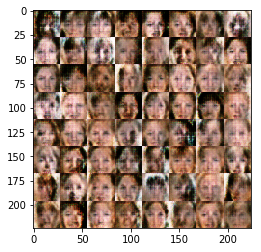

Step: 1000 Epoch 0/1... Discriminator Loss: 1.7222... Generator Loss: 0.3810...
Step: 1020 Epoch 0/1... Discriminator Loss: 1.1947... Generator Loss: 0.8568...
Step: 1040 Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 0.8601...
Step: 1060 Epoch 0/1... Discriminator Loss: 1.3189... Generator Loss: 1.1496...
Step: 1080 Epoch 0/1... Discriminator Loss: 1.7384... Generator Loss: 0.4590...


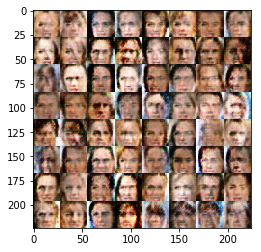

Step: 1100 Epoch 0/1... Discriminator Loss: 1.2242... Generator Loss: 0.9548...
Step: 1120 Epoch 0/1... Discriminator Loss: 1.2634... Generator Loss: 0.7340...
Step: 1140 Epoch 0/1... Discriminator Loss: 1.4216... Generator Loss: 0.6556...
Step: 1160 Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 1.1678...
Step: 1180 Epoch 0/1... Discriminator Loss: 1.2135... Generator Loss: 0.8879...


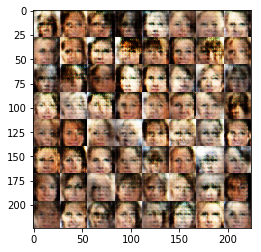

Step: 1200 Epoch 0/1... Discriminator Loss: 1.3580... Generator Loss: 2.0733...
Step: 1220 Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.8991...
Step: 1240 Epoch 0/1... Discriminator Loss: 1.1460... Generator Loss: 0.7631...
Step: 1260 Epoch 0/1... Discriminator Loss: 0.9898... Generator Loss: 1.0023...
Step: 1280 Epoch 0/1... Discriminator Loss: 1.2013... Generator Loss: 0.9327...


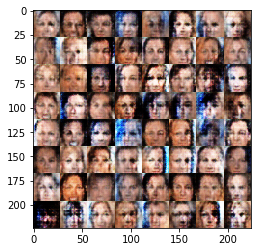

Step: 1300 Epoch 0/1... Discriminator Loss: 1.1013... Generator Loss: 1.2540...
Step: 1320 Epoch 0/1... Discriminator Loss: 1.2435... Generator Loss: 1.0592...
Step: 1340 Epoch 0/1... Discriminator Loss: 1.2721... Generator Loss: 0.6957...
Step: 1360 Epoch 0/1... Discriminator Loss: 1.1282... Generator Loss: 0.8910...
Step: 1380 Epoch 0/1... Discriminator Loss: 1.1768... Generator Loss: 0.8945...


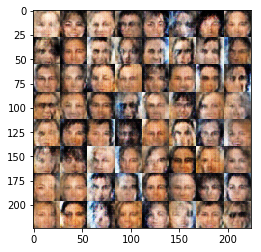

Step: 1400 Epoch 0/1... Discriminator Loss: 1.2651... Generator Loss: 0.6437...
Step: 1420 Epoch 0/1... Discriminator Loss: 1.1533... Generator Loss: 1.0272...
Step: 1440 Epoch 0/1... Discriminator Loss: 1.2034... Generator Loss: 0.8831...
Step: 1460 Epoch 0/1... Discriminator Loss: 1.2909... Generator Loss: 1.0090...
Step: 1480 Epoch 0/1... Discriminator Loss: 1.2886... Generator Loss: 0.7633...


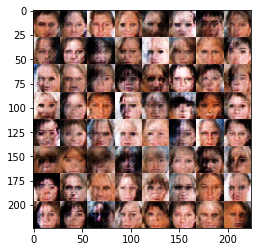

Step: 1500 Epoch 0/1... Discriminator Loss: 1.3908... Generator Loss: 0.7538...
Step: 1520 Epoch 0/1... Discriminator Loss: 1.1294... Generator Loss: 1.1463...
Step: 1540 Epoch 0/1... Discriminator Loss: 1.4318... Generator Loss: 0.6962...
Step: 1560 Epoch 0/1... Discriminator Loss: 1.1921... Generator Loss: 1.2143...
Step: 1580 Epoch 0/1... Discriminator Loss: 0.9692... Generator Loss: 1.0274...


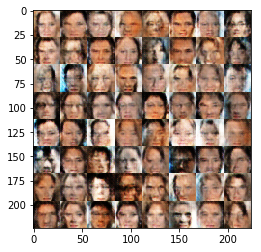

Step: 1600 Epoch 0/1... Discriminator Loss: 1.4166... Generator Loss: 0.5746...
Step: 1620 Epoch 0/1... Discriminator Loss: 1.2722... Generator Loss: 1.0828...
Step: 1640 Epoch 0/1... Discriminator Loss: 1.1068... Generator Loss: 0.9441...
Step: 1660 Epoch 0/1... Discriminator Loss: 1.3619... Generator Loss: 0.8671...
Step: 1680 Epoch 0/1... Discriminator Loss: 1.0988... Generator Loss: 0.9035...


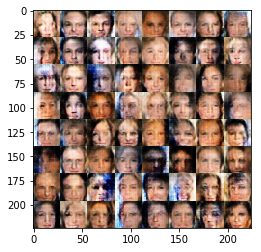

Step: 1700 Epoch 0/1... Discriminator Loss: 1.1930... Generator Loss: 0.7791...
Step: 1720 Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 0.6085...
Step: 1740 Epoch 0/1... Discriminator Loss: 1.2805... Generator Loss: 0.8265...
Step: 1760 Epoch 0/1... Discriminator Loss: 1.3257... Generator Loss: 0.8599...
Step: 1780 Epoch 0/1... Discriminator Loss: 1.2174... Generator Loss: 0.9576...


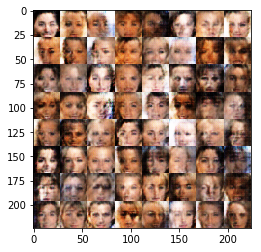

Step: 1800 Epoch 0/1... Discriminator Loss: 1.4591... Generator Loss: 0.8097...
Step: 1820 Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 0.9032...
Step: 1840 Epoch 0/1... Discriminator Loss: 1.1034... Generator Loss: 1.0691...
Step: 1860 Epoch 0/1... Discriminator Loss: 1.2520... Generator Loss: 0.6873...
Step: 1880 Epoch 0/1... Discriminator Loss: 1.3227... Generator Loss: 0.7009...


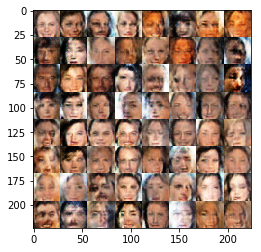

Step: 1900 Epoch 0/1... Discriminator Loss: 1.1979... Generator Loss: 0.7244...
Step: 1920 Epoch 0/1... Discriminator Loss: 1.2201... Generator Loss: 0.7722...
Step: 1940 Epoch 0/1... Discriminator Loss: 1.3651... Generator Loss: 0.7019...
Step: 1960 Epoch 0/1... Discriminator Loss: 1.2106... Generator Loss: 1.0288...
Step: 1980 Epoch 0/1... Discriminator Loss: 1.2252... Generator Loss: 1.0384...


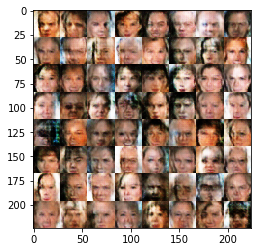

Step: 2000 Epoch 0/1... Discriminator Loss: 1.1617... Generator Loss: 0.8175...
Step: 2020 Epoch 0/1... Discriminator Loss: 1.2395... Generator Loss: 0.9480...
Step: 2040 Epoch 0/1... Discriminator Loss: 1.3391... Generator Loss: 0.6749...
Step: 2060 Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 0.7311...
Step: 2080 Epoch 0/1... Discriminator Loss: 1.2290... Generator Loss: 1.0530...


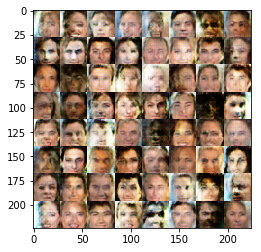

Step: 2100 Epoch 0/1... Discriminator Loss: 1.3903... Generator Loss: 1.0314...
Step: 2120 Epoch 0/1... Discriminator Loss: 1.3632... Generator Loss: 0.5841...
Step: 2140 Epoch 0/1... Discriminator Loss: 1.2599... Generator Loss: 0.8705...
Step: 2160 Epoch 0/1... Discriminator Loss: 1.4087... Generator Loss: 1.0710...
Step: 2180 Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.7143...


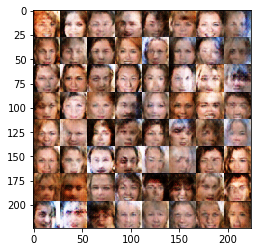

Step: 2200 Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 0.6518...
Step: 2220 Epoch 0/1... Discriminator Loss: 1.3350... Generator Loss: 0.7652...
Step: 2240 Epoch 0/1... Discriminator Loss: 1.2844... Generator Loss: 1.5991...
Step: 2260 Epoch 0/1... Discriminator Loss: 1.1072... Generator Loss: 0.9056...
Step: 2280 Epoch 0/1... Discriminator Loss: 1.2929... Generator Loss: 0.8408...


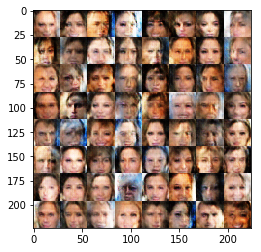

Step: 2300 Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 1.0464...
Step: 2320 Epoch 0/1... Discriminator Loss: 1.3108... Generator Loss: 0.6213...
Step: 2340 Epoch 0/1... Discriminator Loss: 1.4364... Generator Loss: 0.7840...
Step: 2360 Epoch 0/1... Discriminator Loss: 1.2955... Generator Loss: 0.6798...
Step: 2380 Epoch 0/1... Discriminator Loss: 1.2359... Generator Loss: 1.1464...


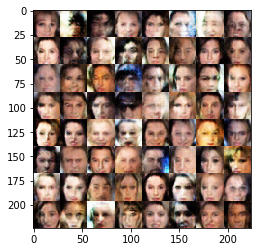

Step: 2400 Epoch 0/1... Discriminator Loss: 1.3593... Generator Loss: 0.6351...
Step: 2420 Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.9181...
Step: 2440 Epoch 0/1... Discriminator Loss: 1.4916... Generator Loss: 0.6165...
Step: 2460 Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 0.8279...
Step: 2480 Epoch 0/1... Discriminator Loss: 1.2026... Generator Loss: 1.1679...


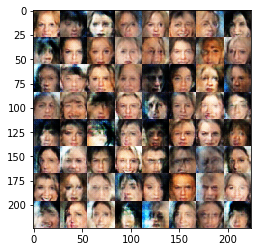

Step: 2500 Epoch 0/1... Discriminator Loss: 1.1368... Generator Loss: 1.1310...
Step: 2520 Epoch 0/1... Discriminator Loss: 1.2626... Generator Loss: 1.0445...
Step: 2540 Epoch 0/1... Discriminator Loss: 1.3341... Generator Loss: 0.8684...
Step: 2560 Epoch 0/1... Discriminator Loss: 1.3320... Generator Loss: 0.9595...
Step: 2580 Epoch 0/1... Discriminator Loss: 1.0478... Generator Loss: 1.0163...


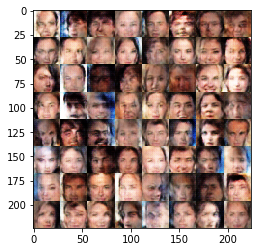

Step: 2600 Epoch 0/1... Discriminator Loss: 1.1796... Generator Loss: 1.0429...
Step: 2620 Epoch 0/1... Discriminator Loss: 1.2655... Generator Loss: 1.0425...
Step: 2640 Epoch 0/1... Discriminator Loss: 1.1890... Generator Loss: 0.9599...
Step: 2660 Epoch 0/1... Discriminator Loss: 1.4369... Generator Loss: 0.9266...
Step: 2680 Epoch 0/1... Discriminator Loss: 1.1704... Generator Loss: 0.8726...


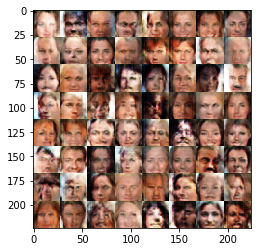

Step: 2700 Epoch 0/1... Discriminator Loss: 1.2903... Generator Loss: 1.3118...
Step: 2720 Epoch 0/1... Discriminator Loss: 1.1334... Generator Loss: 1.0669...
Step: 2740 Epoch 0/1... Discriminator Loss: 1.3884... Generator Loss: 0.7924...
Step: 2760 Epoch 0/1... Discriminator Loss: 1.2274... Generator Loss: 0.8038...
Step: 2780 Epoch 0/1... Discriminator Loss: 1.2449... Generator Loss: 1.1908...


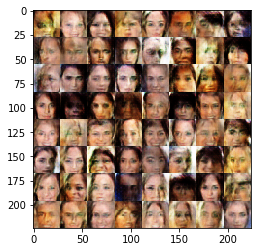

Step: 2800 Epoch 0/1... Discriminator Loss: 1.3197... Generator Loss: 0.9821...
Step: 2820 Epoch 0/1... Discriminator Loss: 1.1665... Generator Loss: 0.9812...
Step: 2840 Epoch 0/1... Discriminator Loss: 1.3433... Generator Loss: 0.7468...
Step: 2860 Epoch 0/1... Discriminator Loss: 1.2022... Generator Loss: 0.7960...
Step: 2880 Epoch 0/1... Discriminator Loss: 1.3324... Generator Loss: 0.5473...


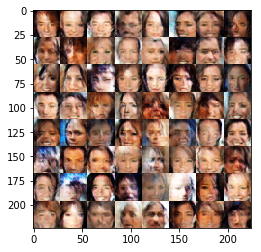

Step: 2900 Epoch 0/1... Discriminator Loss: 1.3229... Generator Loss: 0.9082...
Step: 2920 Epoch 0/1... Discriminator Loss: 1.2692... Generator Loss: 0.7166...
Step: 2940 Epoch 0/1... Discriminator Loss: 1.4157... Generator Loss: 0.6868...
Step: 2960 Epoch 0/1... Discriminator Loss: 1.3157... Generator Loss: 0.7341...
Step: 2980 Epoch 0/1... Discriminator Loss: 1.4386... Generator Loss: 1.0101...


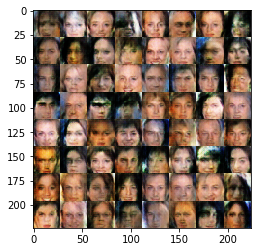

Step: 3000 Epoch 0/1... Discriminator Loss: 1.2599... Generator Loss: 1.0101...
Step: 3020 Epoch 0/1... Discriminator Loss: 1.2233... Generator Loss: 0.8943...
Step: 3040 Epoch 0/1... Discriminator Loss: 1.3326... Generator Loss: 0.8448...
Step: 3060 Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 0.9714...
Step: 3080 Epoch 0/1... Discriminator Loss: 1.1503... Generator Loss: 0.9763...


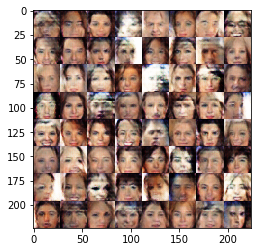

Step: 3100 Epoch 0/1... Discriminator Loss: 1.2506... Generator Loss: 0.8215...
Step: 3120 Epoch 0/1... Discriminator Loss: 1.2370... Generator Loss: 0.7917...
Step: 3140 Epoch 0/1... Discriminator Loss: 1.4226... Generator Loss: 0.8088...
Step: 3160 Epoch 0/1... Discriminator Loss: 1.3528... Generator Loss: 0.8412...
Step: 3180 Epoch 0/1... Discriminator Loss: 1.0909... Generator Loss: 0.9999...


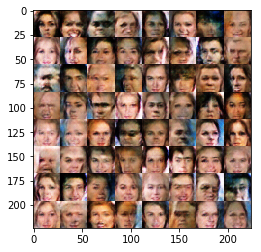

Step: 3200 Epoch 0/1... Discriminator Loss: 1.3195... Generator Loss: 0.8422...
Step: 3220 Epoch 0/1... Discriminator Loss: 1.2660... Generator Loss: 0.8180...
Step: 3240 Epoch 0/1... Discriminator Loss: 1.4111... Generator Loss: 0.8643...
Step: 3260 Epoch 0/1... Discriminator Loss: 1.2064... Generator Loss: 1.1077...
Step: 3280 Epoch 0/1... Discriminator Loss: 1.2753... Generator Loss: 0.9382...


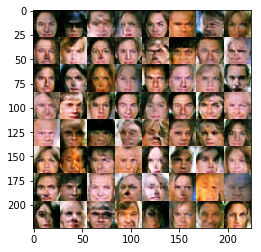

Step: 3300 Epoch 0/1... Discriminator Loss: 1.4380... Generator Loss: 0.7183...
Step: 3320 Epoch 0/1... Discriminator Loss: 1.3155... Generator Loss: 1.1580...
Step: 3340 Epoch 0/1... Discriminator Loss: 1.2158... Generator Loss: 1.0476...
Step: 3360 Epoch 0/1... Discriminator Loss: 1.2182... Generator Loss: 0.9245...
Step: 3380 Epoch 0/1... Discriminator Loss: 1.3005... Generator Loss: 0.7405...


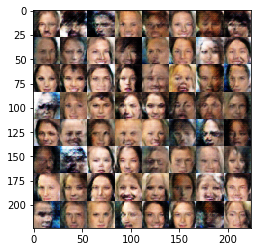

Step: 3400 Epoch 0/1... Discriminator Loss: 1.4342... Generator Loss: 1.1749...
Step: 3420 Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.7573...
Step: 3440 Epoch 0/1... Discriminator Loss: 1.3038... Generator Loss: 1.4156...
Step: 3460 Epoch 0/1... Discriminator Loss: 1.1590... Generator Loss: 0.9269...
Step: 3480 Epoch 0/1... Discriminator Loss: 1.1360... Generator Loss: 0.8589...


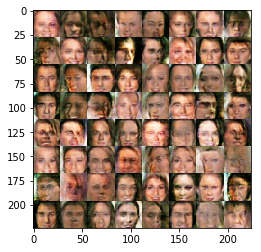

Step: 3500 Epoch 0/1... Discriminator Loss: 1.2076... Generator Loss: 0.9232...
Step: 3520 Epoch 0/1... Discriminator Loss: 1.1252... Generator Loss: 1.0400...
Step: 3540 Epoch 0/1... Discriminator Loss: 1.5146... Generator Loss: 0.5554...
Step: 3560 Epoch 0/1... Discriminator Loss: 1.1619... Generator Loss: 0.8306...
Step: 3580 Epoch 0/1... Discriminator Loss: 1.4062... Generator Loss: 0.8783...


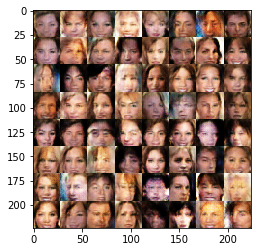

Step: 3600 Epoch 0/1... Discriminator Loss: 1.2076... Generator Loss: 0.9027...
Step: 3620 Epoch 0/1... Discriminator Loss: 1.3557... Generator Loss: 0.7976...
Step: 3640 Epoch 0/1... Discriminator Loss: 1.1946... Generator Loss: 0.8287...
Step: 3660 Epoch 0/1... Discriminator Loss: 1.1729... Generator Loss: 0.6488...
Step: 3680 Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 1.0230...


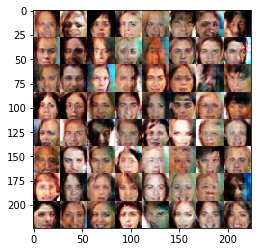

Step: 3700 Epoch 0/1... Discriminator Loss: 1.2646... Generator Loss: 0.7334...
Step: 3720 Epoch 0/1... Discriminator Loss: 1.3019... Generator Loss: 1.0272...
Step: 3740 Epoch 0/1... Discriminator Loss: 1.2267... Generator Loss: 0.9896...
Step: 3760 Epoch 0/1... Discriminator Loss: 1.1657... Generator Loss: 0.9053...
Step: 3780 Epoch 0/1... Discriminator Loss: 1.1795... Generator Loss: 0.9272...


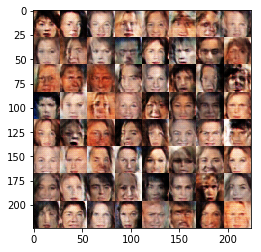

Step: 3800 Epoch 0/1... Discriminator Loss: 1.0878... Generator Loss: 1.1254...
Step: 3820 Epoch 0/1... Discriminator Loss: 1.4197... Generator Loss: 1.0349...
Step: 3840 Epoch 0/1... Discriminator Loss: 1.2877... Generator Loss: 0.5939...
Step: 3860 Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.8886...
Step: 3880 Epoch 0/1... Discriminator Loss: 1.3344... Generator Loss: 0.8045...


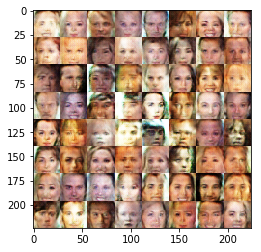

Step: 3900 Epoch 0/1... Discriminator Loss: 1.3566... Generator Loss: 0.6308...
Step: 3920 Epoch 0/1... Discriminator Loss: 1.4369... Generator Loss: 0.6855...
Step: 3940 Epoch 0/1... Discriminator Loss: 1.2939... Generator Loss: 1.1426...
Step: 3960 Epoch 0/1... Discriminator Loss: 1.0520... Generator Loss: 1.0442...
Step: 3980 Epoch 0/1... Discriminator Loss: 1.2091... Generator Loss: 0.8618...


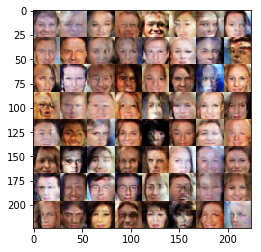

Step: 4000 Epoch 0/1... Discriminator Loss: 1.3115... Generator Loss: 0.6410...
Step: 4020 Epoch 0/1... Discriminator Loss: 1.1705... Generator Loss: 0.8713...
Step: 4040 Epoch 0/1... Discriminator Loss: 1.4247... Generator Loss: 0.8822...
Step: 4060 Epoch 0/1... Discriminator Loss: 1.1976... Generator Loss: 1.0956...
Step: 4080 Epoch 0/1... Discriminator Loss: 1.1152... Generator Loss: 0.8591...


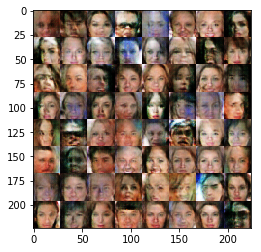

Step: 4100 Epoch 0/1... Discriminator Loss: 1.4181... Generator Loss: 0.7771...
Step: 4120 Epoch 0/1... Discriminator Loss: 1.2707... Generator Loss: 0.9454...
Step: 4140 Epoch 0/1... Discriminator Loss: 1.3356... Generator Loss: 1.2541...
Step: 4160 Epoch 0/1... Discriminator Loss: 1.2277... Generator Loss: 1.2464...
Step: 4180 Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 1.3929...


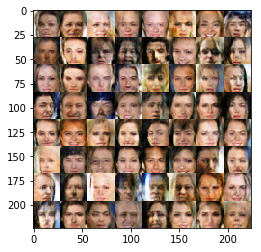

Step: 4200 Epoch 0/1... Discriminator Loss: 1.1316... Generator Loss: 0.8825...
Step: 4220 Epoch 0/1... Discriminator Loss: 1.3671... Generator Loss: 0.6504...
Step: 4240 Epoch 0/1... Discriminator Loss: 1.2676... Generator Loss: 1.0470...
Step: 4260 Epoch 0/1... Discriminator Loss: 1.0861... Generator Loss: 0.8224...
Step: 4280 Epoch 0/1... Discriminator Loss: 1.3584... Generator Loss: 0.7234...


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.